# 0. Install and Import dependencies

In [43]:
# !pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

In [44]:
# Gym stuff
import gymnasium as gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import quantstats as qs

# 1. Get Data

In [45]:
import yfinance as yf

df = yf.Ticker("AMD")
df = df.history(period="max")
df = df.loc['2020-01-01':, ['Open', 'High', 'Low', 'Close', 'Volume']]
print(df.shape)
df.head()

(1082, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02 00:00:00-05:00,46.860001,49.250000,46.630001,49.099998,80331100
2020-01-03 00:00:00-05:00,48.029999,49.389999,47.540001,48.599998,73127400
2020-01-06 00:00:00-05:00,48.020000,48.860001,47.860001,48.389999,47934900
2020-01-07 00:00:00-05:00,49.349998,49.389999,48.040001,48.250000,58061400
2020-01-08 00:00:00-05:00,47.849998,48.299999,47.139999,47.830002,53767000


In [46]:
# ENV_FRAME_BOUND = (5, 250)
# WINDOW_SIZE = 5

TRAIN_WINDOW_SIZE = 10
TRAIN_SIZE = df['2020-01-01':'2022-12-31'].shape[0]
TRAIN_ENV_FRAME_BOUND = (10, TRAIN_SIZE)

SMA_PERIOD = 10

TEST_ENV_FRAME_BOUND = (TRAIN_SIZE + 1, df.shape[0])
TEST_WINDOW_SIZE = 10

# 2.1 Add Custom Indicators

## 2.1.3. Calculate SMA, RSI and OBV

In [47]:
from gym_anytrading.envs import StocksEnv
from finta import TA

In [48]:
df['SMA'] = TA.SMA(df, SMA_PERIOD)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

## 2.1.4. Create New Environments

In [49]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [50]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

env2 = MyCustomEnv(df=df, frame_bound=TRAIN_ENV_FRAME_BOUND, window_size=TRAIN_WINDOW_SIZE)

# 3. Build Environment and Train

In [51]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [52]:
# model = A2C('MlpPolicy', env, verbose=0) 
# model.learn(total_timesteps=10000)

In [53]:
from sb3_contrib import RecurrentPPO
model = RecurrentPPO("MlpLstmPolicy", env, verbose=1, seed=2023)
model.learn(total_timesteps=100000)

Using cpu device


----------------------------
| time/              |     |
|    fps             | 444 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 128 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 49            |
|    iterations           | 2             |
|    time_elapsed         | 5             |
|    total_timesteps      | 256           |
| train/                  |               |
|    approx_kl            | 0.00020455522 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.693        |
|    explained_variance   | -0.0219       |
|    learning_rate        | 0.0003        |
|    loss                 | 6.06          |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00274      |
|    value_loss           | 14.7          |
-------------------------------------------
-----

# 4. Evaluation

In [ ]:
env = MyCustomEnv(df=df, frame_bound=TEST_ENV_FRAME_BOUND, window_size=TEST_WINDOW_SIZE)
observation, info = env.reset()
while True: 
    observation = observation[np.newaxis, ...]
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

info {'total_reward': 59.530033111572266, 'total_profit': 0.6522212928443323, 'position': <Positions.Short: 0>}


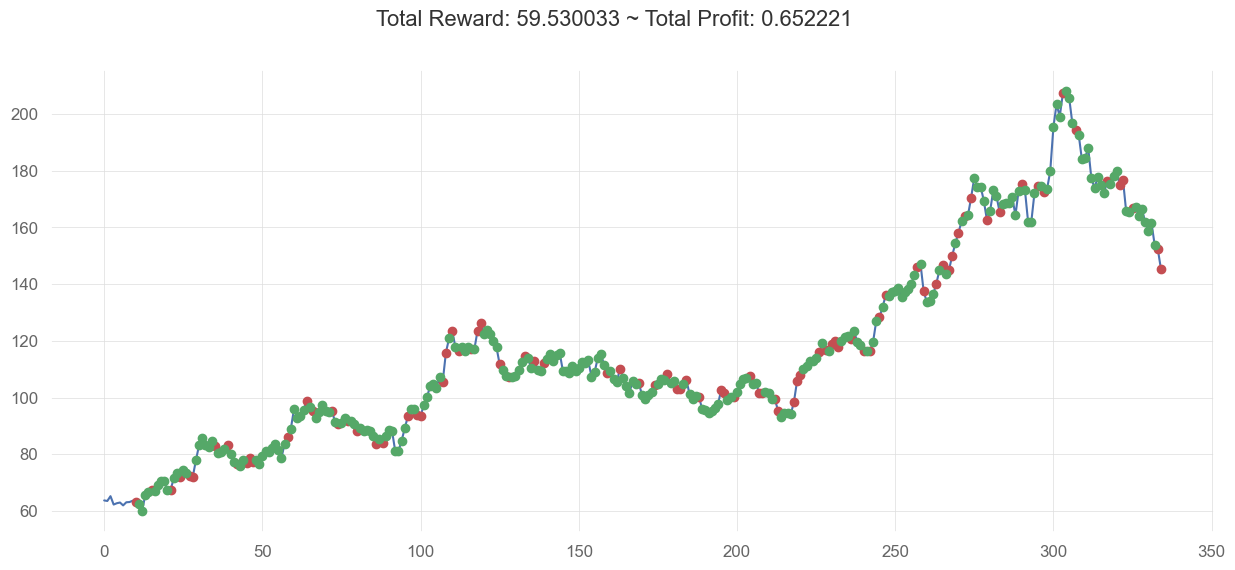

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# 5. QuantStats

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

                           Strategy
-------------------------  ----------
Start Period               2023-01-06
End Period                 2024-04-19
Risk-Free Rate             0.0%
Time in Market             22.0%

Cumulative Return          -34.78%
CAGR﹪                     -20.52%

Sharpe                     -0.71
Prob. Sharpe Ratio         21.5%
Smart Sharpe               -0.71
Sortino                    -0.99
Smart Sortino              -0.98
Sortino/√2                 -0.7
Smart Sortino/√2           -0.7
Omega                      0.78

Max Drawdown               -45.47%
Longest DD Days            390
Volatility (ann.)          37.23%
Calmar                     -0.45
Skew                       0.6
Kurtosis                   16.16

Expected Daily %           -0.13%
Expected Monthly %         -2.64%
Expected Yearly %          -19.24%
Kelly Criterion            -11.13%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.96%
Expected Shortfall (cVaR)  -3.96%

Max Consecutive

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-03-27,2024-04-18,2024-04-19,390,-45.466236,-38.707798
2,2023-02-21,2023-02-24,2023-03-14,21,-6.086359,-5.924964
3,2023-01-20,2023-01-30,2023-02-14,26,-5.743891,-1.828699


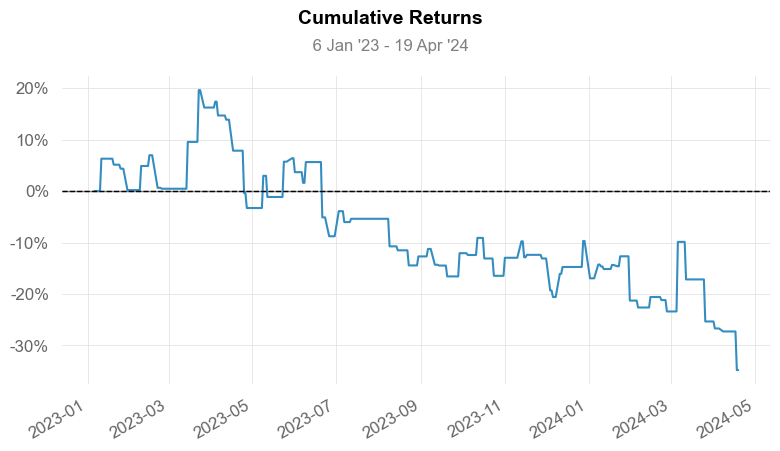

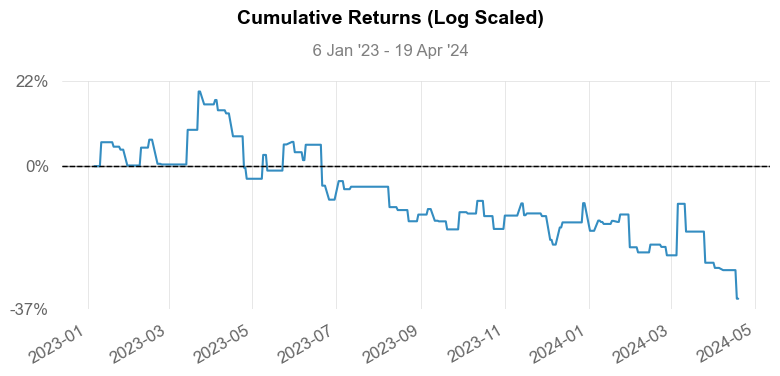

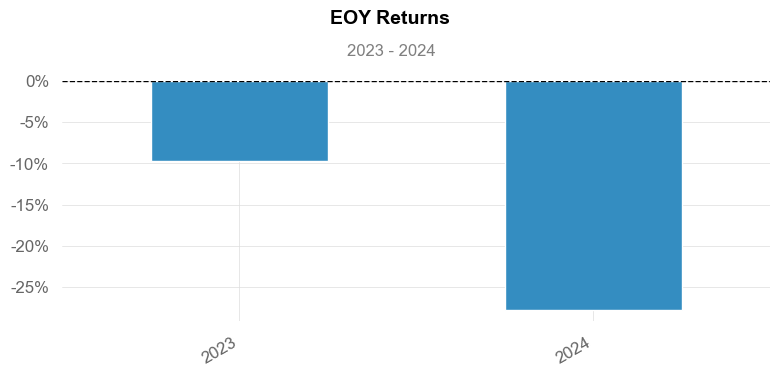

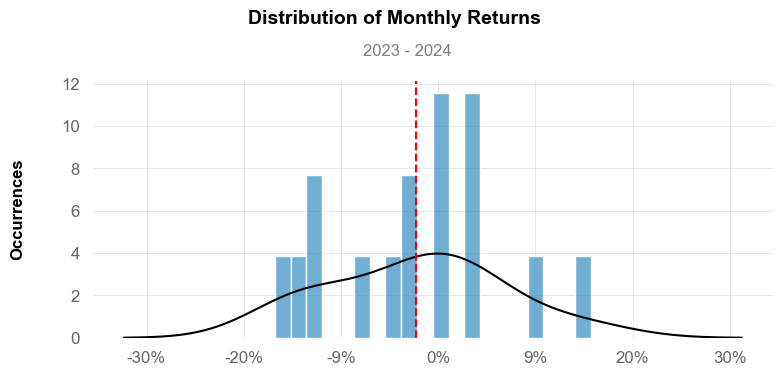

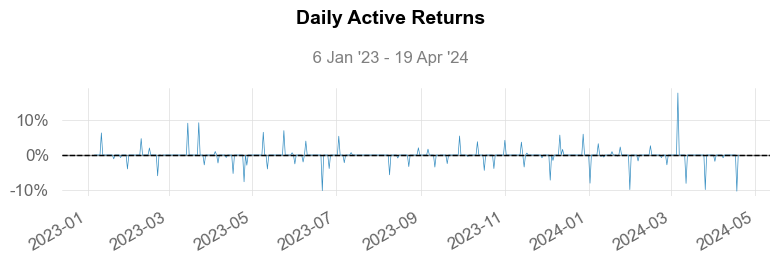

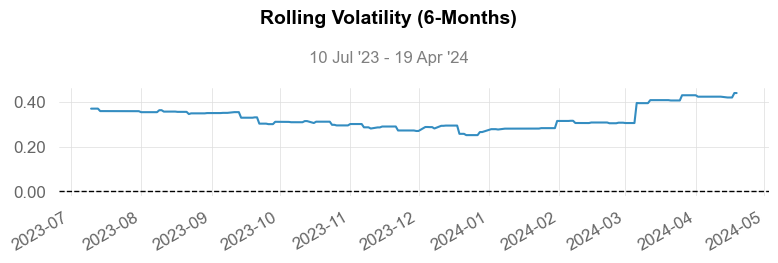

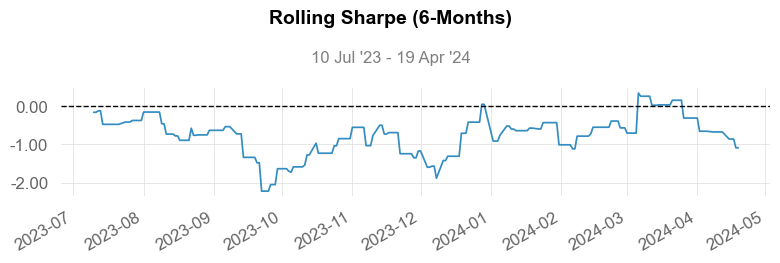

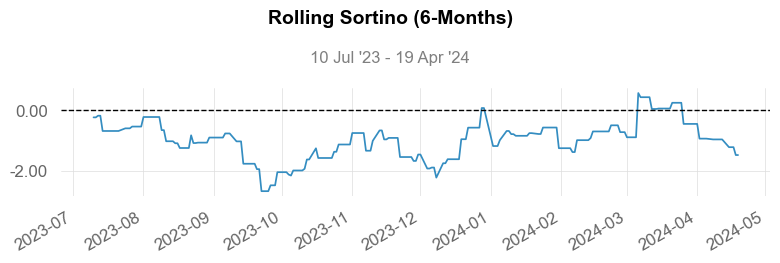

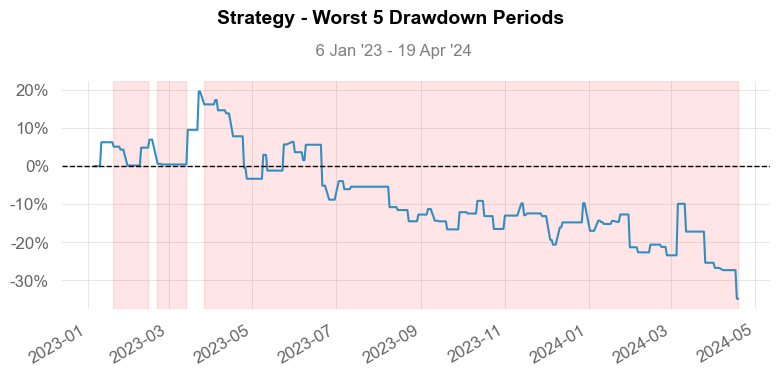

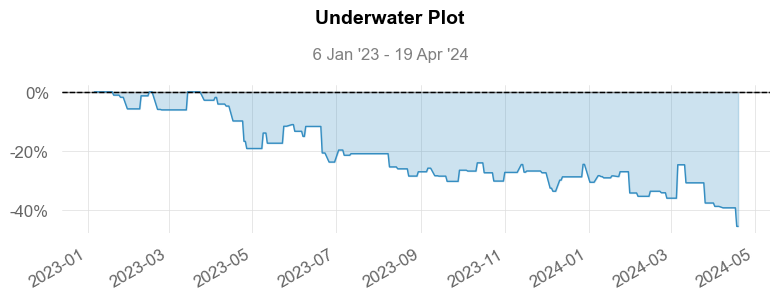

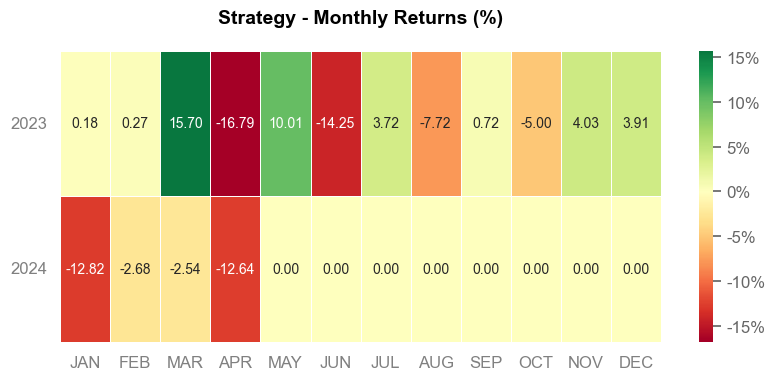

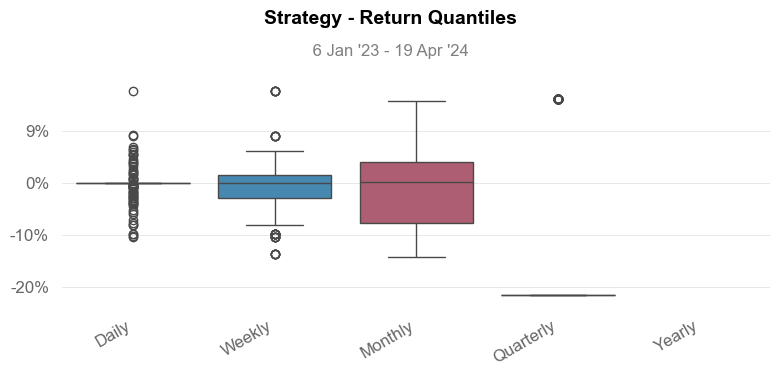

In [ ]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[TEST_ENV_FRAME_BOUND[0]+1:TEST_ENV_FRAME_BOUND[1]])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)